# Lesson 18 — Reinforcement Learning with Continuous State Spaces

This lesson builds directly on Lesson 17 (tabular MDPs + value iteration).  
Now we ask: **what if the state space is continuous or extremely large?**

We focus on a **2D robot** moving in a plane and use it to introduce:

- Discretization and why it breaks (curse of dimensionality)
- Model-based RL with a simulator $s' = f(s,a) + \varepsilon$
- Learning a **linear dynamics model** from data (supervised learning)
- Viewing $V(s)$ as a **regression function** (preview of fitted value iteration)
- Why **stochastic simulators** matter for real-world robustness

**Implementation policy:** NumPy + Matplotlib only (no RL libraries).


## Goals

By the end of this notebook, you should be able to:

1. Explain why tabular RL methods fail for continuous / high-dimensional state spaces.
2. Implement a simple continuous-state robot simulator (deterministic and stochastic).
3. Fit a **linear** dynamics model $\hat s' \approx A s + B a + c$ from trajectory data.
4. Construct regression targets for a value function approximation $\hat V(s)$.
5. Diagnose failure modes: discretization artifacts, model bias, and brittleness from deterministic training.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)


## 1) From Gridworld to Continuous State MDPs

In Lesson 17, the robot lived in a small, discrete grid: a finite set of states.

In many robotics problems, the state is continuous.  
Even for a simple 2D robot, a natural state is:

$$s = (x, y) \in \mathbb{R}^2$$

and an action could be a commanded velocity:

$$a = (v_x, v_y) \in \mathbb{R}^2.$$

The MDP pieces are unchanged:

- states $\mathcal{S}$ (now continuous)
- actions $\mathcal{A}$ (often continuous)
- transition model $P_{sa}(s')$
- reward $R(s)$ or $R(s,a)$
- discount factor $\gamma$

What changes is that we can no longer store $V(s)$ in a table for every state.


## 2) Discretization

The most straightforward idea is **discretization**:

- partition the continuous space into grid cells
- treat each cell as a discrete state
- run tabular value iteration on the discretized MDP

If $s = (x,y)$ and we use $k$ bins per dimension, the number of discrete states is:

$$|\mathcal{S}| = k^2.$$

More generally, for $n$ continuous dimensions:

$$|\mathcal{S}| = k^n.$$

This exponential growth is the **curse of dimensionality**.


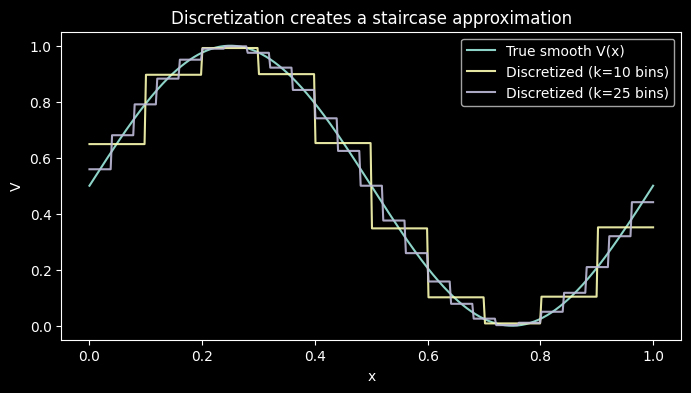

In [2]:
# --- Discretization demo: 1D continuous "value" becomes a staircase under binning ---

# Imagine a smooth target value function on x in [0, 1]
x = np.linspace(0, 1, 400)
V_true = np.sin(2*np.pi*x) * 0.5 + 0.5  # smooth curve in [0,1] (purely illustrative)

def discretize_and_staircase(x, V, k_bins):
    # bin edges and bin ids
    edges = np.linspace(0, 1, k_bins+1)
    # map each x to a bin index
    bin_id = np.clip(np.digitize(x, edges) - 1, 0, k_bins-1)
    # represent each bin by the mean value in that bin
    V_bin = np.zeros(k_bins)
    for b in range(k_bins):
        mask = bin_id == b
        V_bin[b] = V[mask].mean() if np.any(mask) else 0.0
    V_stair = V_bin[bin_id]
    return V_stair, edges

plt.figure(figsize=(8,4))
plt.plot(x, V_true, label="True smooth V(x)")
for k in [10, 25]:
    V_stair, _ = discretize_and_staircase(x, V_true, k_bins=k)
    plt.plot(x, V_stair, label=f"Discretized (k={k} bins)", alpha=0.9)
plt.title("Discretization creates a staircase approximation")
plt.xlabel("x")
plt.ylabel("V")
plt.legend()
plt.show()


In [3]:
# --- Curse of dimensionality: state count explodes with dimension ---

def state_count(k_bins, dim):
    return k_bins**dim

k = 20
for dim in [2, 4, 6, 10]:
    print(f"{dim}D with k={k} bins per dimension -> {state_count(k, dim):,} discrete states")


2D with k=20 bins per dimension -> 400 discrete states
4D with k=20 bins per dimension -> 160,000 discrete states
6D with k=20 bins per dimension -> 64,000,000 discrete states
10D with k=20 bins per dimension -> 10,240,000,000,000 discrete states


## 3) A Simulator / Model of the MDP

A **model** (or simulator) is a function that can generate next states from a current state and action.

Deterministic model:

$$s' = f(s,a)$$

Stochastic model:

$$s' = f(s,a) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0,\Sigma).$$

In practice, if you want a policy to work on a *real* robot, training on a slightly stochastic simulator often improves robustness.


In [4]:
# --- Continuous 2D robot environment (state s=(x,y), action a=(vx,vy)) ---

class Robot2DMDP:
    def __init__(self, dt=0.1, gamma=0.95, noise_std=0.0, action_max=1.0, goal=(1.0, 1.0), goal_radius=0.08):
        self.dt = dt
        self.gamma = gamma
        self.noise_std = float(noise_std)
        self.action_max = float(action_max)
        self.goal = np.array(goal, dtype=np.float64)
        self.goal_radius = float(goal_radius)

    def clip_action(self, a):
        a = np.asarray(a, dtype=np.float64)
        return np.clip(a, -self.action_max, self.action_max)

    def step(self, s, a, rng):
        # dynamics: s' = s + dt * a + noise
        s = np.asarray(s, dtype=np.float64)
        a = self.clip_action(a)
        eps = rng.normal(0.0, self.noise_std, size=2)
        s2 = s + self.dt * a + eps

        # reward: encourage reaching the goal quickly; small control cost
        dist = np.linalg.norm(s2 - self.goal)
        r = -dist - 0.05 * float(a @ a)

        done = dist <= self.goal_radius
        return s2, r, done

    def rollout(self, s0, policy_fn, T=80, seed=0):
        rng = np.random.default_rng(seed)
        s = np.asarray(s0, dtype=np.float64)
        traj = [s.copy()]
        rewards = []
        done = False
        for t in range(T):
            a = policy_fn(s, t)
            s, r, done = self.step(s, a, rng)
            traj.append(s.copy())
            rewards.append(r)
            if done:
                break
        return np.array(traj), np.array(rewards), done

def greedy_to_goal_policy_factory(env: Robot2DMDP, gain=1.0):
    # a simple hand-coded policy for generating data: push toward goal
    def pi(s, t):
        vec = env.goal - s
        return gain * vec / (np.linalg.norm(vec) + 1e-12)
    return pi


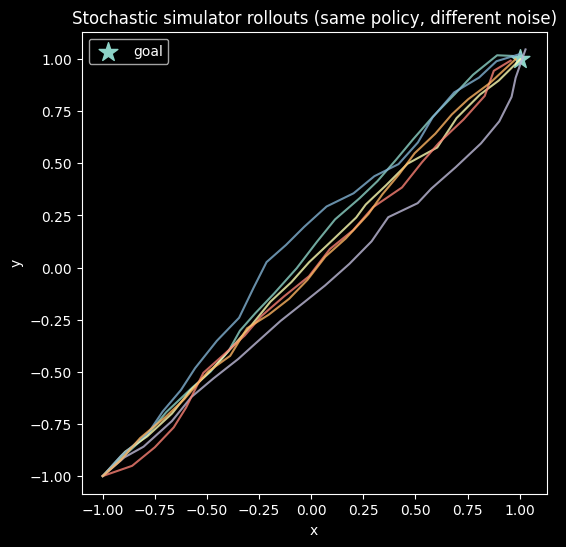

In [5]:
# --- Deterministic vs stochastic simulator: trajectories diverge under noise ---

env_det = Robot2DMDP(noise_std=0.0)
env_sto = Robot2DMDP(noise_std=0.02)

s0 = np.array([-1.0, -1.0])
pi = greedy_to_goal_policy_factory(env_det, gain=2.0)

traj_det, _, _ = env_det.rollout(s0, pi, T=120, seed=0)

plt.figure(figsize=(6,6))
plt.plot(traj_det[:,0], traj_det[:,1], linewidth=2, label="deterministic")
plt.scatter([env_det.goal[0]],[env_det.goal[1]], marker="*", s=200, label="goal")
plt.title("Deterministic simulator rollout")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.axis("equal"); plt.show()

plt.figure(figsize=(6,6))
for k in range(6):
    traj_sto, _, _ = env_sto.rollout(s0, pi, T=120, seed=k)
    plt.plot(traj_sto[:,0], traj_sto[:,1], alpha=0.8)
plt.scatter([env_sto.goal[0]],[env_sto.goal[1]], marker="*", s=200, label="goal")
plt.title("Stochastic simulator rollouts (same policy, different noise)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.axis("equal"); plt.show()


## 4) Learning a Linear Dynamics Model from Data

Suppose we can collect experience tuples:

$$(s^{(i)}, a^{(i)}, s'^{(i)}).$$

A simple supervised learning approach is to fit a **linear** model:

$$\hat s' = A s + B a + c.$$

We can estimate $(A,B,c)$ with least squares (just linear regression).


In [6]:
# --- Collect experience (s, a, s') for supervised model learning ---

def collect_transitions(env, policy_fn, n_episodes=60, T=80, seed=0):
    rng = np.random.default_rng(seed)
    S = []
    A = []
    Sp = []
    for ep in range(n_episodes):
        # random start states in a box
        s = rng.uniform(low=-1.2, high=0.2, size=2)
        for t in range(T):
            a = policy_fn(s, t)
            s2, _, done = env.step(s, a, rng)
            S.append(s.copy())
            A.append(env.clip_action(a).copy())
            Sp.append(s2.copy())
            s = s2
            if done:
                break
    return np.array(S), np.array(A), np.array(Sp)

env_train = Robot2DMDP(noise_std=0.02)
pi_train = greedy_to_goal_policy_factory(env_train, gain=2.0)

S, A, Sp = collect_transitions(env_train, pi_train, n_episodes=80, T=90, seed=1)
print("dataset shapes:", S.shape, A.shape, Sp.shape)


dataset shapes: (1385, 2) (1385, 2) (1385, 2)


In [7]:
# --- Fit linear dynamics: s' ≈ A s + B a + c using least squares ---

def fit_linear_dynamics(S, A, Sp):
    # Design matrix: [s_x, s_y, a_x, a_y, 1]
    X = np.hstack([S, A, np.ones((S.shape[0], 1))])
    Y = Sp  # (N, 2)
    # Solve X W ≈ Y in least squares
    W, *_ = np.linalg.lstsq(X, Y, rcond=None)  # W: (5, 2)
    return W

W = fit_linear_dynamics(S, A, Sp)
print("W shape:", W.shape)

def predict_next(W, s, a):
    x = np.concatenate([s, a, np.array([1.0])], axis=0)  # (5,)
    return x @ W  # (2,)

# Evaluate one-step prediction error on a held-out split
rng = np.random.default_rng(0)
idx = rng.permutation(len(S))
split = int(0.8 * len(S))
te = idx[split:]

pred = np.array([predict_next(W, S[i], A[i]) for i in te])
mse = np.mean((pred - Sp[te])**2)
print("one-step MSE (held-out):", mse)


W shape: (5, 2)
one-step MSE (held-out): 0.00039464203679387817


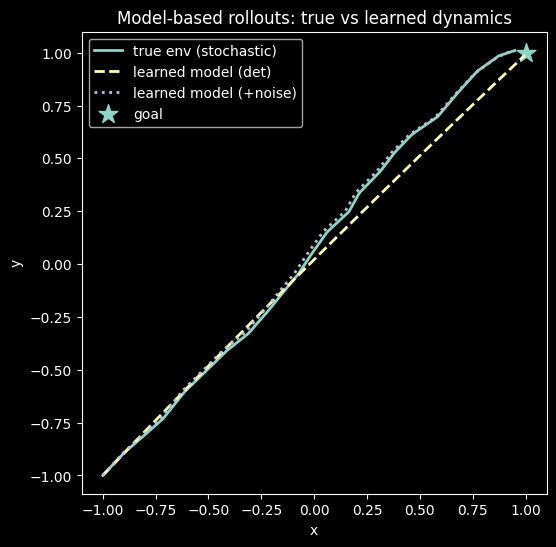

In [8]:
# --- Compare rollouts: true simulator vs learned linear model ---

def rollout_learned_model(W, env: Robot2DMDP, s0, policy_fn, T=120, noise_std=0.0, seed=0):
    rng = np.random.default_rng(seed)
    s = np.array(s0, dtype=np.float64)
    traj = [s.copy()]
    for t in range(T):
        a = env.clip_action(policy_fn(s, t))
        s2 = predict_next(W, s, a)
        # optional: add noise to the learned model
        if noise_std > 0:
            s2 = s2 + rng.normal(0.0, noise_std, size=2)
        traj.append(s2.copy())
        s = s2
        if np.linalg.norm(s - env.goal) <= env.goal_radius:
            break
    return np.array(traj)

env_eval = Robot2DMDP(noise_std=0.02)
pi_eval = greedy_to_goal_policy_factory(env_eval, gain=2.0)
s0 = np.array([-1.0, -1.0])

traj_true, _, _ = env_eval.rollout(s0, pi_eval, T=140, seed=7)
traj_model_det = rollout_learned_model(W, env_eval, s0, pi_eval, T=140, noise_std=0.0, seed=7)
traj_model_sto = rollout_learned_model(W, env_eval, s0, pi_eval, T=140, noise_std=0.02, seed=7)

plt.figure(figsize=(6,6))
plt.plot(traj_true[:,0], traj_true[:,1], linewidth=2, label="true env (stochastic)")
plt.plot(traj_model_det[:,0], traj_model_det[:,1], "--", linewidth=2, label="learned model (det)")
plt.plot(traj_model_sto[:,0], traj_model_sto[:,1], ":", linewidth=2, label="learned model (+noise)")
plt.scatter([env_eval.goal[0]],[env_eval.goal[1]], marker="*", s=200, label="goal")
plt.title("Model-based rollouts: true vs learned dynamics")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.axis("equal"); plt.show()


## 5) Value Functions as Regression Problems (Preview)

In tabular value iteration, we compute:

$$V_{k+1}(s) = \max_a \sum_{s'} P_{sa}(s')\bigl(R(s,a,s') + \gamma V_k(s')\bigr).$$

When $s$ is continuous, we approximate $V(s)$ by a parameterized function:

$$\hat V(s) = \theta^T \phi(s).$$

In this notebook we keep it **linear in parameters** and use very simple features:

$$\phi(s) = [1, x, y]^T.$$

This is a minimal preview of **fitted value iteration**: using regression to approximate the value function.


In [9]:
# --- Value approximation as regression: Monte Carlo returns under a fixed policy ---

def discounted_return(rewards, gamma):
    G = 0.0
    powg = 1.0
    for r in rewards:
        G += powg * float(r)
        powg *= gamma
    return G

def mc_value_dataset(env, policy_fn, n_episodes=300, T=90, seed=0):
    rng = np.random.default_rng(seed)
    X = []
    y = []
    for ep in range(n_episodes):
        s0 = rng.uniform(low=-1.2, high=0.2, size=2)
        traj, rewards, _ = env.rollout(s0, policy_fn, T=T, seed=rng.integers(0, 10_000_000))
        G = discounted_return(rewards, env.gamma)
        X.append(s0.copy())
        y.append(G)
    return np.array(X), np.array(y)

env_val = Robot2DMDP(noise_std=0.02, gamma=0.95)
pi_val = greedy_to_goal_policy_factory(env_val, gain=2.0)

Xv, yv = mc_value_dataset(env_val, pi_val, n_episodes=500, T=120, seed=3)
print("value dataset:", Xv.shape, yv.shape, "targets: mean", yv.mean(), "std", yv.std())

# Linear value function: V(s) = theta0 + theta1 x + theta2 y
Phi = np.hstack([np.ones((Xv.shape[0],1)), Xv])   # (N,3)
theta, *_ = np.linalg.lstsq(Phi, yv, rcond=None)
print("theta:", theta)

def V_hat(s):
    s = np.asarray(s, dtype=np.float64)
    return float(np.array([1.0, s[0], s[1]]) @ theta)

# Quick diagnostics: fit quality
pred = Phi @ theta
rmse = np.sqrt(np.mean((pred - yv)**2))
print("RMSE:", rmse)


value dataset: (500, 2) (500,) targets: mean -14.608409189732743 std 4.24032585872596
theta: [-6.94615601  7.54076967  7.66258436]
RMSE: 1.2191253943254323


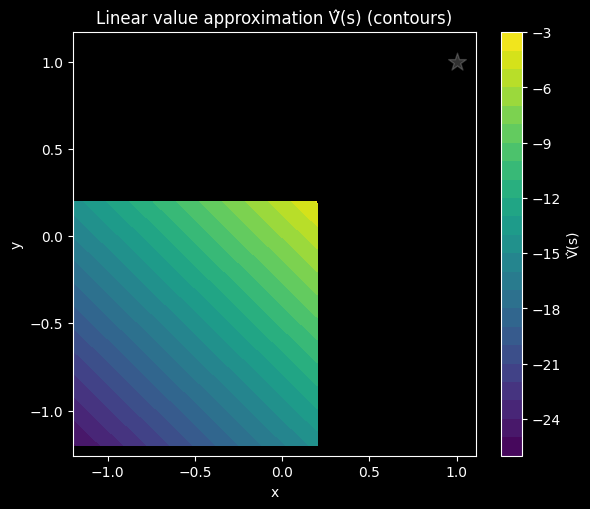

In [15]:
# --- Visualization: estimated V(s) surface (3D) + 2D contour ---

# Grid over state space
xs = np.linspace(-1.2, 0.2, 80)
ys = np.linspace(-1.2, 0.2, 80)
XX, YY = np.meshgrid(xs, ys)
ZZ = theta[0] + theta[1]*XX + theta[2]*YY

# 2D contour (recommended for clarity)
plt.figure(figsize=(6.5,5.5))
cs = plt.contourf(XX, YY, ZZ, levels=25)
plt.colorbar(cs, label="V̂(s)")
plt.scatter([env_val.goal[0]],[env_val.goal[1]], marker="*", s=180, color="white", alpha=0.2)
plt.title("Linear value approximation V̂(s) (contours)")
plt.xlabel("x"); plt.ylabel("y"); plt.axis("equal")
plt.show()


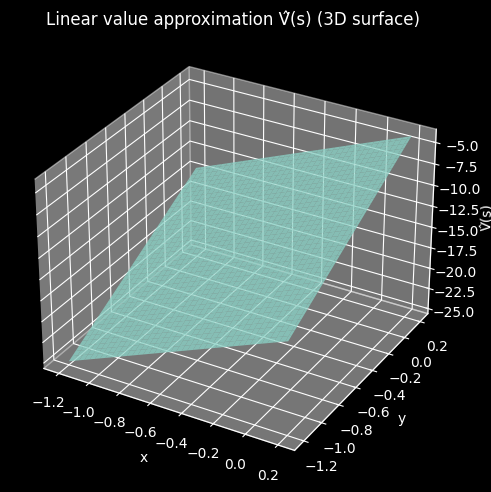

In [14]:
# 3D surface (one, as requested)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(7.2,5.8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(XX, YY, ZZ, alpha=0.80, linewidth=0)
ax.set_title("Linear value approximation V̂(s) (3D surface)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("V̂(s)")
plt.show()

## 6) Diagnostics / Sanity Checks

In continuous-state RL, debugging usually means checking:

1. **Simulator sanity**: trajectories look physically plausible.
2. **Noise realism**: stochastic rollouts diversify outcomes (not explode).
3. **Model error**: one-step prediction error is small enough for planning to be meaningful.
4. **Value approximation bias**: linear $\hat V(s)$ cannot capture complex geometry.

A key mindset shift from tabular RL:

> In continuous RL, failure is often due to approximation error, not "the algorithm".


## Key Takeaways (Lesson 18)

### When discretization is acceptable
- Low-dimensional continuous state spaces (e.g. 2D–4D) with modest resolution.
- When you only need a rough controller and the environment dynamics are simple.
- When you can tolerate **staircase artifacts** in $\hat V(s)$.

### Discretization failure modes
- **Curse of dimensionality**: $k^n$ states explodes quickly.
- **Aliasing**: different continuous states fall into the same bin, forcing the same action.
- **Boundary artifacts**: tiny changes in state can flip bins and cause unstable behavior.
- Computational cost: running value iteration on millions of bins becomes impractical.

### Why a simulator (model) matters in model-based RL
- A simulator lets you generate transitions $(s,a,s')$ without physically crashing a robot.
- With a model, you can plan by simulating outcomes of actions.
- Real dynamics are noisy: **stochastic simulators** often lead to policies that generalize better.

### Learning a model is supervised learning
- Fitting $\hat s' = A s + B a + c$ is just least squares.
- Diagnostics look like standard ML:
  - train/test split
  - one-step MSE
  - inspecting rollouts (does the model drift?)

### Deterministic vs stochastic training
- Policies trained only on deterministic simulators can be brittle:
  - they overfit to perfect dynamics
  - they may fail when small disturbances occur
- Adding noise during simulation often improves robustness.

### Bias/variance behavior (continuous RL)
- **Discretization**: high bias (staircase), variance depends on data collection.
- **Linear dynamics model**: high bias if real dynamics are nonlinear; low variance with enough data.
- **Linear value approximation**: high bias when optimal value is nonlinear in state; low variance with enough samples.

### Practical diagnostics you should always run
- Plot trajectories for several random seeds (do they look stable?).
- Measure one-step prediction error for the learned model.
- Compare rollouts in:
  - true environment vs learned model
  - deterministic vs stochastic settings
- Plot $\hat V(s)$ as a contour map. If it looks implausibly linear, it *is*.

### Connections to later lessons
- This notebook sets up the core idea behind **fitted value iteration**:
  - create targets using Bellman backups or Monte Carlo returns
  - fit $\hat V(s)$ with regression
  - improve the policy using the fitted value function
- In Lesson 19, we will implement the full fitted value iteration loop:
  1. sample states
  2. compute Bellman targets using a simulator/model
  3. regress $\hat V$
  4. repeat until convergence (or stabilization)
